In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load Tesla stock data
data = pd.read_csv(r"C:\Users\INDIA\Downloads\TSLA.csv")

# Convert 'Date' to datetime format and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# We'll work only with the 'Close' prices
close_prices = data[['Close']] 
ds=close_prices.values #convert to numpyarray
train_data_len= int(np.ceil(len(data) * 0.8))

In [247]:
print(data.head(),'\n')

print(data.info(),'\n')

print(data.isnull().sum(),'\n')

print(data.drop_duplicates(inplace=True),'\n')

data

                 Open   High        Low      Close  Adj Close    Volume
Date                                                                   
2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2416 non-null   float64
 1   High       2416 non-null   float64
 2   Low        2416 non-null   float64
 3   Close      2416 non-null   float64
 4   Adj Close  2416 non-null   float64
 5   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 132.1 K

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...
2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700


In [248]:
# Normalize the Close Prices
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

train_data= scaled_close[:train_data_len]

In [249]:
#Create Time-Series Sequences
X, y = [], []
window_size = 60 # 60 days

for i in range(window_size, len(train_data)):
        X.append(train_data[i - window_size:i, 0])
        y.append(train_data[i, 0])

X , y = np.array(X), np.array(y)



# Reshape X to be [samples, time steps, features] for RNN/LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [250]:
#Train-Test Split
split_index = int(len(X) * 0.8)

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

#Callbacks,Modelcheckpoint for Saving Best Models
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_rnn = ModelCheckpoint("best_rnn_model.h5", monitor='val_loss', save_best_only=True)
checkpoint_lstm = ModelCheckpoint("best_lstm_model.h5", monitor='val_loss', save_best_only=True)

In [251]:
#Build SimpleRNN Model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, input_shape=(window_size, 1)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

rnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stop, checkpoint_rnn])

Epoch 1/30


C:\Users\INDIA\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0221

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0218 - val_loss: 0.0012
Epoch 2/30
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0015 - val_loss: 9.2335e-04
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0012

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0012 - val_loss: 7.3817e-04
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.5395e-04 - val_loss: 7.4690e-04
Epoch 5/30
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6972e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.6880e-04 - val_loss: 6.0092e-04
Epoch 6/30
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5330e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.5632e-04 - val_loss: 5.2261e-04
Epoch 7/30
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6714e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.6948e-04 - val_loss: 4.6238e-04
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.8820e-04 - val_loss: 5.0837e-04
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8082e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.7921e-04 - val_loss: 4.4496e-04
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7083e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.6974e-04 - val_loss: 3.2395e-04
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.4901e-04 - val_loss: 3.5840e-04
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.3455e-04 - val_loss: 3.5887e-04
Epoch 13/30
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7439e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.7338e-04 - val_loss: 2.7875e-04
Epoch 14/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.7680e-04 - val_loss: 5.8036e-04
Epoch 15/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.3426e-04 - val_loss: 3.7045e-04
Epoch 16/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.5892e-04 - val_loss: 4.6609e-04
Epoch 17/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.6648e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.6600e-04 - val_loss: 2.3742e-04
Epoch 18/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.3788e-04 - val_loss: 3.8745e-04
Epoch 19/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.4172e-04 - val_loss: 3.3713e-04
Epoch 20/30
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2950e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.3038e-04 - val_loss: 2.2380e-04
Epoch 21/30
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8117e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.8178e-04 - val_loss: 2.1717e-04
Epoch 22/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3928e-04 - val_loss: 4.1978e-04
Epoch 23/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6996e-04 - val_loss: 2.4742e-04
Epoch 24/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0803e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0809e-04 - val_loss: 2.0574e-04
Epoch 25/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.8432e-04 - val_loss: 2.1244e-04
Epoch 26/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5857e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.5892e-04 - val_loss: 2.0409e-04
Epoch 27/30
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6367e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.6397e-04 - val_loss: 1.8213e-04
Epoch 28/30
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0227e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.0005e-04 - val_loss: 1.7015e-04
Epoch 29/30
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5541e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.5507e-04 - val_loss: 1.6650e-04
Epoch 30/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.4638e-04 - val_loss: 1.6903e-04


In [252]:
#Build LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(window_size, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stop, checkpoint_lstm])

Epoch 1/30
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0063

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0061 - val_loss: 6.5649e-04
Epoch 2/30
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.2899e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 5.2817e-04 - val_loss: 3.3772e-04
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.2869e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 4.2772e-04 - val_loss: 3.2785e-04
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 3.9303e-04 - val_loss: 3.9638e-04
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.1661e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 4.1567e-04 - val_loss: 2.6809e-04
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.9434e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.9475e-04 - val_loss: 2.5469e-04
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 3.3011e-04 - val_loss: 2.6272e-04
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.0154e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 3.0166e-04 - val_loss: 2.3049e-04
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.9923e-04 - val_loss: 3.3487e-04
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 3.2695e-04 - val_loss: 4.4293e-04
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.6155e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.6148e-04 - val_loss: 2.0898e-04
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.4856e-04 - val_loss: 2.2737e-04
Epoch 13/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.0142e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 3.0047e-04 - val_loss: 2.0875e-04
Epoch 14/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.7033e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.6976e-04 - val_loss: 1.9005e-04
Epoch 15/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.4330e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.4313e-04 - val_loss: 1.8702e-04
Epoch 16/30
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.1099e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 2.1097e-04 - val_loss: 1.8593e-04
Epoch 17/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.9400e-04 - val_loss: 1.9481e-04
Epoch 18/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.2756e-04 - val_loss: 2.4313e-04
Epoch 19/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.6005e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.5978e-04 - val_loss: 1.7246e-04
Epoch 20/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.1191e-04 - val_loss: 2.4038e-04
Epoch 21/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.4733e-04 - val_loss: 2.3956e-04
Epoch 22/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.9257e-04 - val_loss: 2.2845e-04
Epoch 23/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.4454e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.4449e-04 - val_loss: 1.7222e-04
Epoch 24/30
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.1564e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.1499e-04 - val_loss: 1.6322e-04
Epoch 25/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.0087e-04 - val_loss: 1.7480e-04
Epoch 26/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.9849e-04 - val_loss: 1.6592e-04
Epoch 27/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.6999e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.7019e-04 - val_loss: 1.5707e-04
Epoch 28/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.9981e-04 - val_loss: 1.5983e-04
Epoch 29/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.8069e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.8060e-04 - val_loss: 1.5594e-04
Epoch 30/30
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.5213e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.5344e-04 - val_loss: 1.5089e-04


In [253]:
#Load the Best Models Saved
best_rnn = load_model("best_rnn_model.h5")
best_lstm = load_model("best_lstm_model.h5")

#Predictions
rnn_pred = best_rnn.predict(X_test)
lstm_pred = best_lstm.predict(X_test)

#Inverse transform predictions and actual values
rnn_pred_inv = scaler.inverse_transform(rnn_pred)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


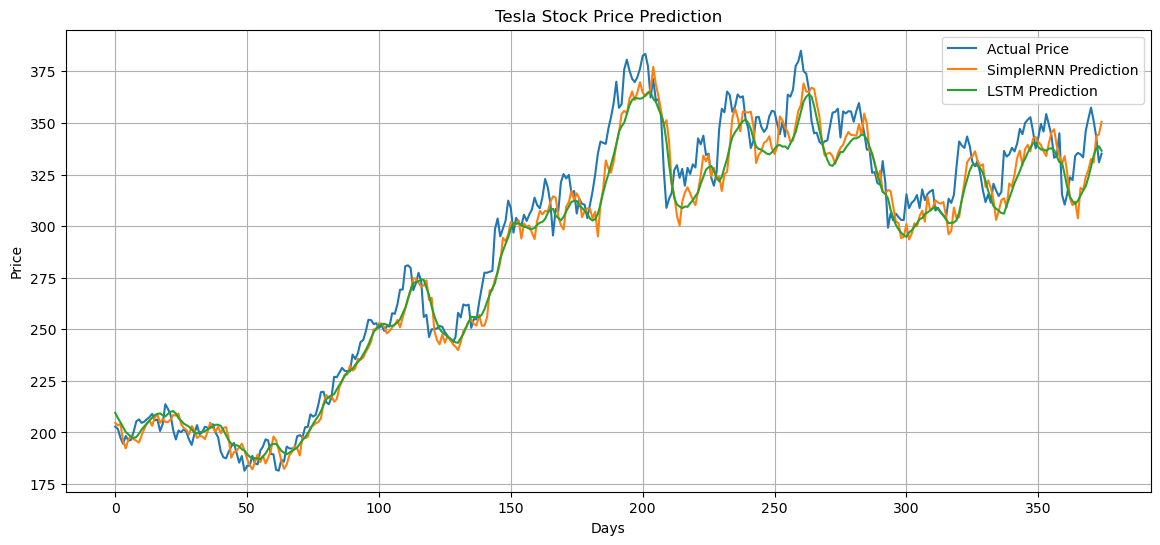

In [254]:
#Plotting Predictions vs Actual Prices
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(rnn_pred_inv, label='SimpleRNN Prediction')
plt.plot(lstm_pred_inv, label='LSTM Prediction')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [279]:
rnn_mse = mean_squared_error(y_test_inv, rnn_pred_inv)
lstm_mse = mean_squared_error(y_test_inv, lstm_pred_inv)

print("SimpleRNN MSE:", rnn_mse)
print("LSTM MSE:", lstm_mse)

SimpleRNN MSE: 167.11793670879524
LSTM MSE: 163.64310001756732


In [281]:
#Since LSTM Model has lower score for MSE, it is better for predictions